# 👇这里进行深度学习（神经网络）的测试

## 初始化超参数

In [141]:
# L2正则项参数
regularizers = 0.01
# 学习率
learning_rate = 0.01
# 迭代次数
epochs = 2000
# 批数量
batch_size = 64

(60, 4)
2/2 [==============================] - 0s 2ms/step


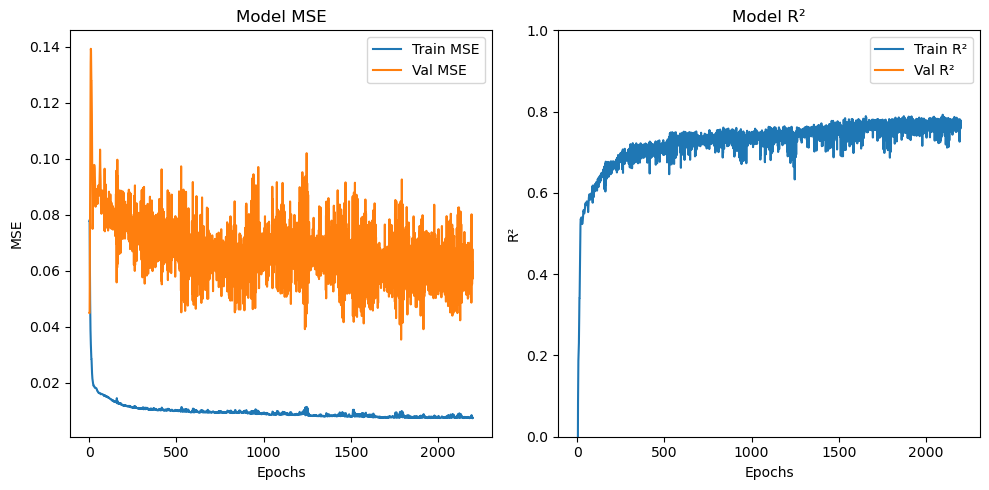

INFO:tensorflow:Assets written to: saved_model/my_model_tep\assets


INFO:tensorflow:Assets written to: saved_model/my_model_tep\assets


2/2 [==============================] - 0s 2ms/step
Mean Squared Error: 0.013069840888682164
R² Score: 0.7647517557959314
Mean Absolute Error: 0.08449587065139881
Explained Variance Score: 0.7864110607803126
2/2 [==============================] - 0s 1ms/step


In [145]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler


class lossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_mse = []  # 用于记录训练集的均方误差
        self.val_mse = []  # 用于记录验证集的均方误差
        self.losses = []  # 用于记录损失值
        self.train_r2_scores = []  # 记录训练集的R²
        self.val_r2_scores = []  # 记录验证集的R²

        self.counter = 0
   
    def on_epoch_end(self, batch, logs={}):
        if self.counter % 10 == 0:
            self.train_mse.append(logs.get('mean_squared_error'))  # 记录训练集的均方误差
            self.val_mse.append(logs.get('val_mean_squared_error'))  # 记录验证集的均方误差
            self.losses.append(logs.get('loss'))
            train_pred = self.model.predict(x)
            r2_train = r2_score(y, train_pred)
            self.train_r2_scores.append(r2_train)
            # x_val = self.validation_data[0]
            # y_val = self.validation_data[1]
            # val_pred = self.model.predict(x_val)
            # r2_val = r2_score(y_val, val_pred)
            # self.val_r2_scores.append(r2_val)

        self.counter += 1
        
        self.train_mse.append(logs.get('mean_squared_error'))  # 记录训练集的均方误差
        self.val_mse.append(logs.get('val_mean_squared_error'))  # 记录验证集的均方误差
        self.losses.append(logs.get('loss'))
        train_pred = self.model.predict(x)
        
        # x_val = self.validation_data[0]
        # y_val = self.validation_data[1]
        # val_pred = self.model.predict(x_val)
        r2_train = r2_score(y, train_pred)
        # r2_val = r2_score(y_val, val_pred)
        self.train_r2_scores.append(r2_train)
        # self.val_r2_scores.append(r2_val)



# 从Excel文件读取数据
data = pd.read_excel('20230927_grinding_data.xlsx', header=None)
# 打磨力 进给速度 磨头转速 砂纸目数 表面粗糙度
# print(data.iloc[1:, :4])
# 获取各列数据
x = data.iloc[1:, :4].applymap(lambda x: math.log(x)).values
print(x.shape)
y = data.iloc[1:, 4].apply(lambda x: math.log(x)).values

# 使用 Min-Max 缩放将数据缩放到 0 到 1 之间（归一化）
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()


# 使用高级 Keras API 构建模型。
####################################
# 可修改参数（网络模型的数量、连接形式、正则项的选择）
model = tf.keras.Sequential([
    # tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
    # 添加L2正则项
    tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularizers), input_shape=(4,)),
    tf.keras.layers.Dense(1)
])

# # 展示模型的结构
# model.summary()

##################################
# 可修改参数（优化算法的选择【SGD、Adam】）
# 编译模型。
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error'])

history = lossHistory()

#   自己写一下验证集产生
  

###################################
# 可修改参数（训练次数，批大小）
# 开始训练 + 保存
# verbose: 控制训练过程中输出的信息。它可以取以下值：

# 0：不输出训练信息。
# 1：显示一个进度条，告诉你每个周期的训练情况。
# 2：只显示每个周期的总损失。
model.fit(x, y, epochs = epochs, verbose=0, batch_size = batch_size, callbacks=[history], validation_split=0.1) #  validation_split=0.2


# 绘制训练过程的曲线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history.train_mse) + 1), history.train_mse, label='Train MSE')
plt.plot(range(1, len(history.val_mse) + 1), history.val_mse, label='Val MSE')
plt.title('Model MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(history.train_r2_scores) + 1), history.train_r2_scores, label='Train R²')
plt.plot(range(1, len(history.val_r2_scores) + 1), history.val_r2_scores, label='Val R²')
plt.title('Model R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.ylim(0, 1)  # 这里设置y轴范围为0到正无穷
plt.legend()

plt.tight_layout()
plt.show()




model.save('saved_model/my_model_tep')

pred = model.predict(x)
# 使用评估指标
mse = mean_squared_error(y, pred)
r2 = r2_score(y, pred)
mae = mean_absolute_error(y, pred)
evs = explained_variance_score(y, pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Explained Variance Score: {evs}")

# 导入模型文件
new_model = tf.keras.models.load_model('saved_model/my_model_original')
# 预测结果。
pred_new = new_model.predict(x)
r2_new = r2_score(y, pred_new)
mse_new = mean_squared_error(y, pred_new)
if r2 > r2_new and mse_new < mse:
    model.save('saved_model/my_model_original')
    model.save(f'saved_model/my_model_lr{learning_rate}_batch{batch_size}_reg{regularizers}_epochs{epochs}')

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 10)                50        
                                                                 
 dense_149 (Dense)           (None, 1)                 11        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 2ms/step


C:\Users\86133\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86133\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


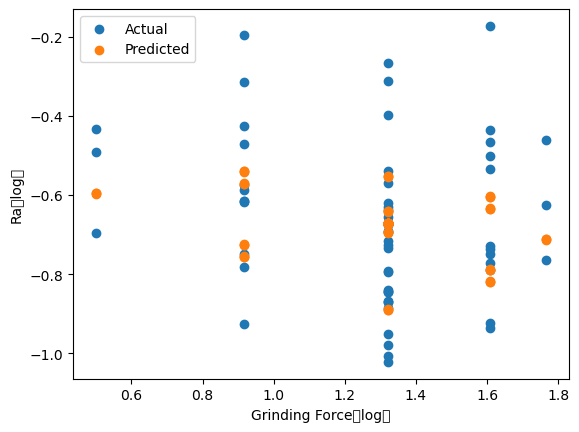

Mean Squared Error: 0.028684816698606428
R² Score: 0.28283821360280426
Mean Absolute Error: 0.13732054451337347
Explained Variance Score: 0.28551858133092967


In [6]:
# 导入模型文件
new_model = tf.keras.models.load_model('saved_model/my_model_original')
# 检验模型
new_model.summary()

# model = new_model

# 预测结果。
pred = new_model.predict(x)

# 绘制拟合结果。
plt.scatter(x[:, 0], y, label='Actual')
plt.scatter(x[:, 0], pred, label='Predicted')
plt.xlabel('Grinding Force(log)')
plt.ylabel('Ra(log)')
plt.legend()
plt.show()

# 使用评估指标
mse = mean_squared_error(y, pred)
r2 = r2_score(y, pred)
mae = mean_absolute_error(y, pred)
evs = explained_variance_score(y, pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Explained Variance Score: {evs}")

## 绘制曲面图

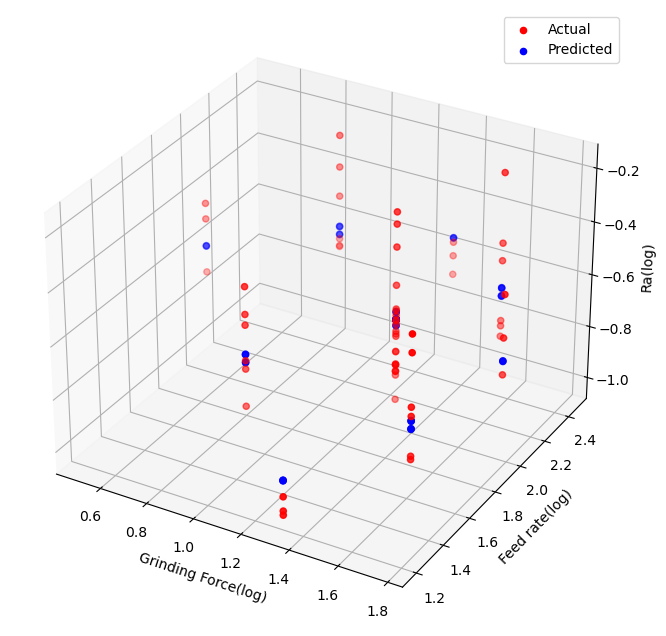

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# 创建一个 3D 图形对象
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
ax.scatter(x[:, 0], x[:, 1], y, c='r', label='Actual')
ax.scatter(x[:, 0], x[:, 1], pred, c='b', label='Predicted')

# 添加轴标签
ax.set_xlabel('Grinding Force(log)')
ax.set_ylabel('Feed rate(log)')
ax.set_zlabel('Ra(log)')

# 添加图例
ax.legend()

plt.show()

313/313 [==============================] - 0s 598us/step


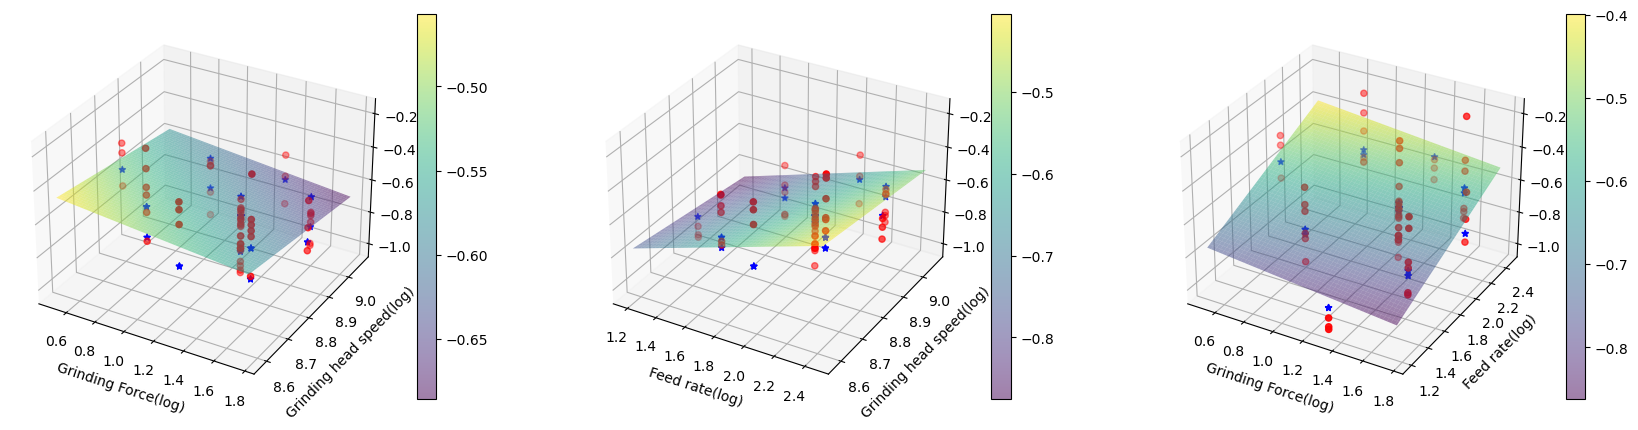

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# 绘制x1，x2和y，pred

# 生成一组新的数据，包括x1、x2、x3、x4
x1 = np.linspace(min(x[:, 0]), max(x[:, 0]), 100)
x2 = np.linspace(min(x[:, 1]), max(x[:, 1]), 100)
x3 = np.linspace(min(x[:, 2]), max(x[:, 2]), 100)
# # print(x1.shape)
# # 创建一个网格
# X1_mesh, X2_mesh = np.meshgrid(x1, x2)
# X1 = X1_mesh.reshape(-1, )
# X2 = X2_mesh.reshape(-1, )
# # print(X1.shape)
# # 获取预测值
# X3 = np.full_like(X1, np.log(7000))
# X4 = np.full_like(X2, np.log(600))

# # 将新的数据合并成一个数组
# new_x = np.column_stack((X1, X2, X3, X4))

# # 预测新的数据
# pred_new = model.predict(new_x)

# # 将预测结果变形回网格的形状
# Z = pred_new.reshape(X1_mesh.shape)

# # print(Z.shape)
# # 创建3D图
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')

# # 绘制散点图
# ax.scatter(x[:, 0], x[:, 1], y, c='r', label='Actual', marker='o')
# ax.scatter(x[:, 0], x[:, 1], pred, c='b', label='Predicted', marker='x')

# # 绘制曲面图
# surf = ax.plot_surface(X1_mesh, X2_mesh, Z, cmap='viridis', alpha=0.5, antialiased=True)

# # 添加颜色条
# fig.colorbar(surf)

# # 添加标签
# ax.set_xlabel('打磨力（log）')
# ax.set_ylabel('进给速度（log）')
# ax.set_zlabel('表面粗糙度（log）')

# plt.show()

###############################################################
# 分别绘制x1，x2，x3和y，pred

# 生成x1和x3的网格
X1_mesh_1, X3_mesh_1 = np.meshgrid(x1, x3)
X1 = X1_mesh_1.reshape(-1, )
X3 = X3_mesh_1.reshape(-1, )

# 获取预测值
X2 = np.full_like(X1, np.log(7.5))
X4 = np.full_like(X3, np.log(600))

# 将新的数据合并成一个数组
new_x_1 = np.column_stack((X1, X2, X3, X4))

# 预测新的数据
pred_new_1 = model.predict(new_x_1)

# 将预测结果变形回网格的形状
Z_1 = pred_new_1.reshape(X1_mesh_1.shape)

# 生成x2和x3的网格
X2_mesh_2, X3_mesh_2 = np.meshgrid(x2, x3)
X2 = X2_mesh_2.reshape(-1, )
X3 = X3_mesh_2.reshape(-1, )

# 获取预测值
X1 = np.full_like(X2, np.log(3.75))
X4 = np.full_like(X3, np.log(600))

# 将新的数据合并成一个数组
new_x_2 = np.column_stack((X1, X2, X3, X4))

# 预测新的数据
pred_new_2 = model.predict(new_x_2)

# 将预测结果变形回网格的形状
Z_2 = pred_new_2.reshape(X2_mesh_2.shape)

# 生成x1和x2的网格
X1_mesh_3, X2_mesh_3 = np.meshgrid(x1, x2)
X1 = X1_mesh_3.reshape(-1, )
X2 = X2_mesh_3.reshape(-1, )

# 获取预测值
X3 = np.full_like(X1, np.log(7000))
X4 = np.full_like(X2, np.log(600))

# 将新的数据合并成一个数组
new_x_3 = np.column_stack((X1, X2, X3, X4))

# 预测新的数据
pred_new_3 = model.predict(new_x_3)

# 将预测结果变形回网格的形状
Z_3 = pred_new_3.reshape(X1_mesh_3.shape)

# 创建子图
fig, axs = plt.subplots(1, 3, figsize=(21, 5), subplot_kw={'projection': '3d'})

# 绘制散点图
axs[0].scatter(x[:, 0], x[:, 2], y, c='r', label='Actual', marker='o')
axs[0].scatter(x[:, 0], x[:, 2], pred, c='b', label='Actual', marker='*')
axs[1].scatter(x[:, 1], x[:, 2], y, c='r', label='Actual', marker='o')
axs[1].scatter(x[:, 1], x[:, 2], pred, c='b', label='Actual', marker='*')
axs[2].scatter(x[:, 0], x[:, 1], y, c='r', label='Actual', marker='o')
axs[2].scatter(x[:, 0], x[:, 1], pred, c='b', label='Actual', marker='*')

# 绘制曲面图
surf1 = axs[0].plot_surface(X1_mesh_1, X3_mesh_1, Z_1, cmap='viridis', alpha=0.5, antialiased=True)
surf2 = axs[1].plot_surface(X2_mesh_2, X3_mesh_2, Z_2, cmap='viridis', alpha=0.5, antialiased=True)
surf3 = axs[2].plot_surface(X1_mesh_3, X2_mesh_3, Z_3, cmap='viridis', alpha=0.5, antialiased=True)

# 添加颜色条
fig.colorbar(surf1, ax=axs[0])
fig.colorbar(surf2, ax=axs[1])
fig.colorbar(surf3, ax=axs[2])

# 添加标签
axs[0].set_xlabel('Grinding Force(log)')
axs[0].set_ylabel('Grinding head speed(log)')
axs[0].set_zlabel('Ra(log)')


axs[1].set_xlabel('Feed rate(log)')
axs[1].set_ylabel('Grinding head speed(log)')
axs[1].set_zlabel('Ra(log)')

axs[2].set_xlabel('Grinding Force(log)')
axs[2].set_ylabel('Feed rate(log)')
axs[2].set_zlabel('Ra(log)')

plt.show()
